<a href="https://colab.research.google.com/github/anthonymelson/portfolio/blob/master/Breast_Cancer_Probabilistic_v_Label.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Dataset
from sklearn.datasets import load_breast_cancer

#Data Manipulation
import pandas as pd
import numpy as np

#Plotting and Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Model Training 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

#Feature Selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFpr, chi2
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

#Scoring and Evaluation
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.metrics import log_loss
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
%matplotlib inline
plt.style.use('fivethirtyeight')

In [281]:
X, y = load_breast_cancer(return_X_y=True)
data = load_breast_cancer()
feature_names = data.feature_names
X.shape

(569, 30)

In [0]:
clf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=74).fit(X, y)
fi = clf.feature_importances_
df = pd.DataFrame(fi, feature_names)
df['FI_Rank'] =  df[0].rank(ascending=False)

df = df.reset_index()
df = df.rename(columns={'index': 'FeaturesFI', 0:"Feature Importance"})
df = df.sort_values('FI_Rank', ascending=True)
df1 = df[df['Feature Importance'] > 0.08]
df1_best = list(df1.index)
df2_best = list(df2.index)

In [0]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(X,y, random_state=157)
df = pd.DataFrame(mi, feature_names)
df['MI_Rank'] =  df[0].rank(ascending=False)

df = df.reset_index()
df = df.rename(columns={'index': 'FeaturesMI', 0:"Mutual Information"})
df = df.sort_values('MI_Rank', ascending=True)
df2 = df[df['Mutual Information'] > 0.4]

In [284]:
[value for value in df1_best if value in df2_best]
features = df1.join(df2).drop(['FeaturesMI'], axis=1)

,FeaturesFI,Feature Importance,FI_Rank,Mutual Information,MI_Rank
27,worst concave points,0.142614,1.0,0.436514,5.0
22,worst perimeter,0.130170,2.0,0.473275,1.0
7,mean concave points,0.124734,3.0,0.441447,4.0
23,worst area,0.098240,4.0,0.463845,2.0


In [285]:
sel = VarianceThreshold(threshold=0.0009)
sel.fit(X)
X = sel.transform(X)
X.shape

(569, 20)

In [286]:
clf = LassoCV(cv=5).fit(X, y)
sfm = SelectFromModel(clf, threshold=0.00001)
sfm.fit(X, y)
X = sfm.transform(X)
X.shape

(569, 4)

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


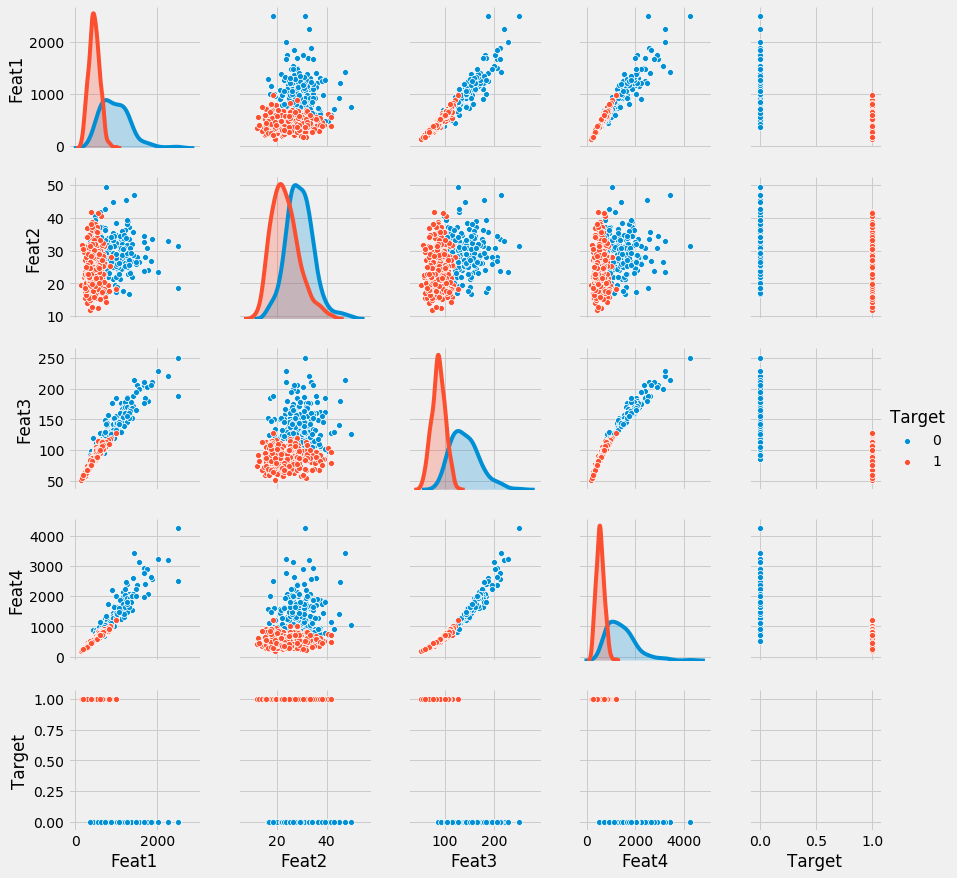

In [287]:
Xy = pd.DataFrame(X, columns=['Feat1', 'Feat2', 'Feat3', 'Feat4'])
yy = pd.DataFrame(y)
Xy['Target'] = yy[0]

pp = sns.pairplot(data=Xy, hue="Target")

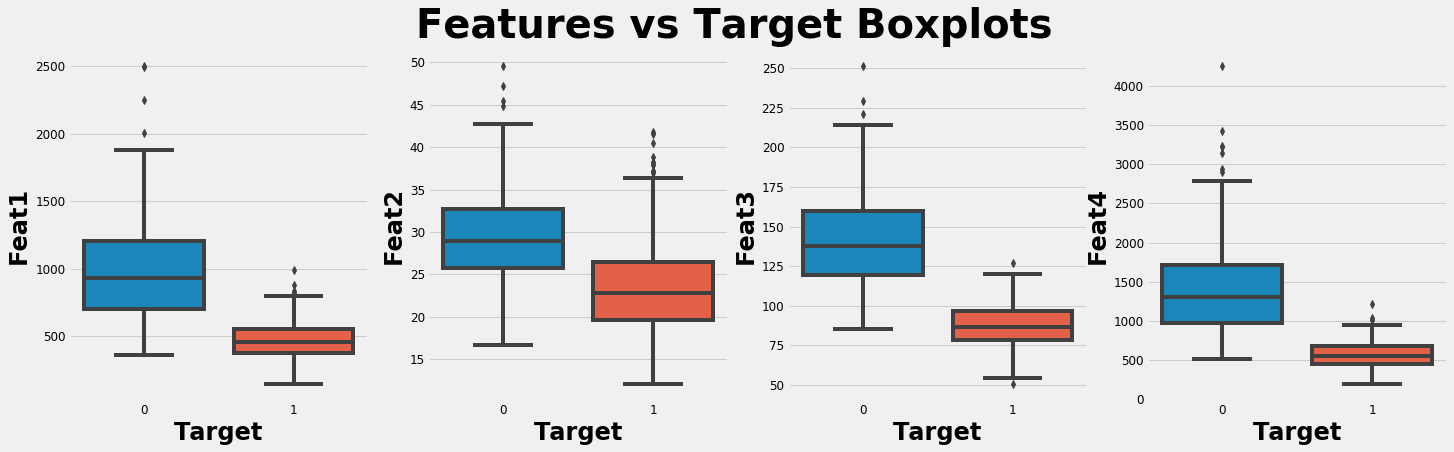

In [288]:
fig, axs = plt.subplots(1, 4)
fig.set_figheight(6)
fig.set_figwidth(22)
fig.suptitle("Features vs Target Boxplots", fontsize=40, fontweight='bold')
one = sns.boxplot(data=Xy, x='Target', y='Feat1', orient='v', ax=axs[0])
one.set_xlabel("Target",fontsize=24, fontweight='bold')
one.set_ylabel("Feat1",fontsize=24, fontweight='bold')
one.tick_params(labelsize=12)
two = sns.boxplot(data=Xy, x='Target', y='Feat2', orient='v', ax=axs[1])
two.set_xlabel("Target",fontsize=24, fontweight='bold')
two.set_ylabel("Feat2",fontsize=24, fontweight='bold')
two.tick_params(labelsize=12)
three = sns.boxplot(data=Xy, x='Target', y='Feat3', orient='v', ax=axs[2])
three.set_xlabel("Target",fontsize=24, fontweight='bold')
three.set_ylabel("Feat3",fontsize=24, fontweight='bold')
three.tick_params(labelsize=12)
four = sns.boxplot(data=Xy, x='Target', y='Feat4', orient='v', ax=axs[3])
four.set_xlabel("Target",fontsize=24, fontweight='bold')
four.set_ylabel("Feat4",fontsize=24, fontweight='bold')
four.tick_params(labelsize=12)
plt.show()

In [0]:
X, X_test, y, y_test = train_test_split(
    X, y, test_size=0.4, random_state=105)

In [0]:
Log_Reg_Param = LogisticRegressionCV(cv=1)

param_grid = {
    'Cs': [1,2,3,4,5,6,7,8,9],
    'cv': [5],
    'random_state': [310],
    'penalty': ["l2"],
    'solver': ['liblinear', 'lbfgs'],
    'class_weight': ['balanced', 'None']
}

In [0]:
Param_List = GridSearchCV(estimator=Log_Reg_Param, param_grid=param_grid, cv=5).fit(X, y)
Best_Params = Param_List.best_params_

In [292]:
LR = LogisticRegressionCV(**Best_Params).fit(X, y)
LR

LogisticRegressionCV(Cs=9, class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=310, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [0]:
Predicted_Probs = LR.predict_proba(X_test)[:,1]
Predicted_Labels = LR.predict(X_test)

In [0]:
#Convert to DF
y_df = pd.DataFrame(y_test)
#Total Observations
tot_obs = y_df.count()
#Total Minority Class (reference class)
tot_min_class = tot_obs - y_df.sum()
#Base Rate for Minority (Reference) Class = Total Minority Class / Total Observations
min_base_rate = tot_min_class/tot_obs

In [0]:
true_prob_bin, pred_prob_bin = calibration_curve( y_test, Predicted_Probs,n_bins=5, strategy='quantile', normalize=True)

In [0]:
ll = log_loss(y_test, Predicted_Probs).round(5)
ll_label = "Log-Loss = {}".format(ll)

bs = brier_score_loss(y_test, Predicted_Probs, pos_label=1).round(5)
bs_label = "Brier Score = {}".format(bs)

min_bss = (1 - (bs/min_base_rate)).round(5)[0]
min_bss_label = "Minority BSS = {}".format(min_bss)

maj_base_rate = y_df.sum()/tot_obs
maj_bss = (1 - (bs/maj_base_rate)).round(5)[0]
maj_bss_label = "Majority BSS = {}".format(maj_bss)

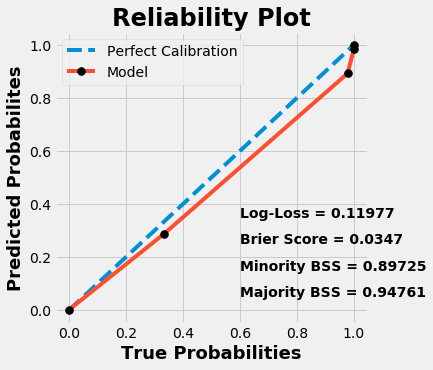

In [297]:
plt.figure(figsize=(5,5))
plt.xlabel('True Probabilities', fontsize=18, fontweight='bold')
plt.ylabel('Predicted Probabilites', fontsize=18, fontweight='bold')
plt.plot([0, 1], [0, 1], label='Perfect Calibration', linestyle='--')
plt.plot(true_prob_bin, pred_prob_bin, label='Model', marker='.', markeredgecolor='black', markerfacecolor='black', markersize='15')
plt.text(0.6, 0.05, maj_bss_label, fontsize=14, fontweight='bold')
plt.text(0.6, 0.15, min_bss_label, fontsize=14, fontweight='bold')
plt.text(0.6, 0.25, bs_label, fontsize=14, fontweight='bold')
plt.text(0.6, 0.35, ll_label, fontsize=14, fontweight='bold')
plt.title('Reliability Plot', fontsize=24, fontweight='bold')
plt.legend(loc='best',fontsize=14)
plt.show()

In [298]:
scores = {
          "Precision":precision_score(y_test, Predicted_Labels),
          "Recall": recall_score(y_test, Predicted_Labels) ,
          "Accuracy": accuracy_score(y_test, Predicted_Labels), 
          "Balanced Accuracy":balanced_accuracy_score(y_test, Predicted_Labels),
          "F1 Score": f1_score(y_test, Predicted_Labels),
          }
pd.DataFrame.from_dict(scores, orient='index', columns=['Scores'])

,Scores
Precision,0.973333
Recall,0.966887
Accuracy,0.960526
Balanced Accuracy,0.957470
F1 Score,0.970100


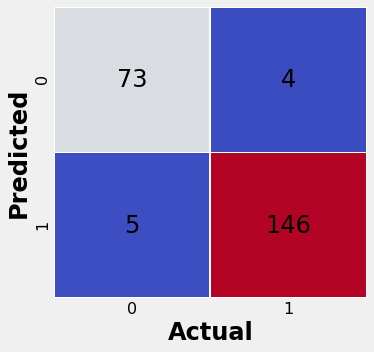

In [299]:
cm = confusion_matrix(y_test, Predicted_Labels)
plt.figure(figsize=(5,5))
ax = sns.heatmap(pd.DataFrame(cm), cmap='coolwarm', annot=True, fmt='d', cbar=False, linecolor='white', linewidths=1, annot_kws={"fontsize":24, "color":'0'})
ax.set_xlabel("Actual",fontsize=24, fontweight='bold')
ax.set_ylabel("Predicted",fontsize=24, fontweight='bold')
ax.tick_params(labelsize=16)
plt.show()

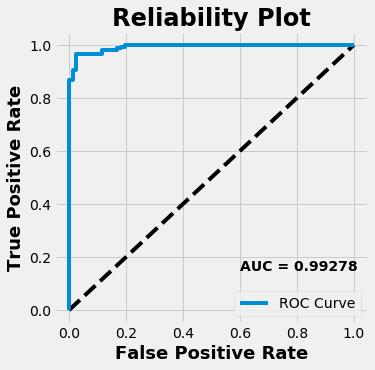

In [301]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, Predicted_Probs, pos_label=1)
AUC = roc_auc_score(y_test, Predicted_Probs).round(5)
AUC_label = "AUC = {}".format(AUC)

plt.figure(figsize=(5,5))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate',fontsize=18, fontweight='bold')
plt.ylabel('True Positive Rate',fontsize=18, fontweight='bold')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.text(0.6, 0.15, AUC_label, fontsize=14, fontweight='bold')
plt.title('Reliability Plot', fontsize=24, fontweight='bold')
plt.show()